## Predicting the presence of a Heart Disease using `LogisticRegressor` Classification Algorithm 
### The Dataset
We'll also be working on a real-world dataset: the [Heart Disease Data Set](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the **UCI Machine Learning Repository**. This dataset comes from the famous **Cleveland Clinic Foundation**, which recorded information on various patient characteristics. We shall use this dataset to build a **classification** model using **`LogisticRegressor`** algorithm that can **predict the presence of heart disease in an individual**. This a prime example of how machine learning can help solve problems that have a real impact on people's lives.

### Load and Explore the dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from classification_evaluation import cap_curve
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
heart = pd.read_csv('./data/heart_disease.csv')
print(heart.shape)
heart.head()

(303, 15)


,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


### Note: 
This is a reduced and partially cleaned version of the dataset prepared for performing a **binary classification**. The original dataset has **multiple classes**.
### Checking for missing data and dropping the first column which is irrelevant.

In [3]:
heart.drop('Unnamed: 0', axis = 1, inplace = True)
z = heart.isnull().sum()
print(f'Columns with missing values:\n{z[z > 0]}')

Columns with missing values:
Series([], dtype: int64)


### The Features
The dataset has the following features:
* **age**: age in years
* **sex**: sex (1 = male; 0 = female)
* **cp**: chest pain type
    * **1**: typical angina
    * **2**: atypical angina
    * **3**: non-anginal pain
    * **4**: asymptomatic
* **trestbps**: resting blood pressure (in mm Hg on admission to the hospital)
* **chol**: serum cholestoral in mg/dl
* **fbs**: (fasting blood sugar > 120 mg/dl)  
    * **1** = true; 
    * **0** = false
* **restecg**: resting electrocardiographic results
    * **0**: normal
    * **1**: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * **2**: showing probable or definite left ventricular hypertrophy by Estes' criteria
* **thalach**: maximum heart rate achieved
* **exang**: exercise induced angina 
    * **1** = yes; 
    * **0** = no
* **oldpeak** = ST depression induced by exercise relative to rest
* **slope**: the slope of the peak exercise ST segment
    * **1**: upsloping
    * **2**: flat
    * **3**: downsloping
* **ca**: number of major vessels (0-3) colored by flourosopy
* **thal**: 
    * **3** = normal; 
    * **6** = fixed defect; 
    * **7** = reversable defect
* **present**: the target 
    * **1** = the presence of heart disease, 
    * **0** = the absence of heart disease

In [4]:
heart.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca           object
thal         object
present       int64
dtype: object

## Check Features Distributions
### Target: `present`

In [5]:
target = heart.present.value_counts()
target

present
0    164
1    139
Name: count, dtype: int64

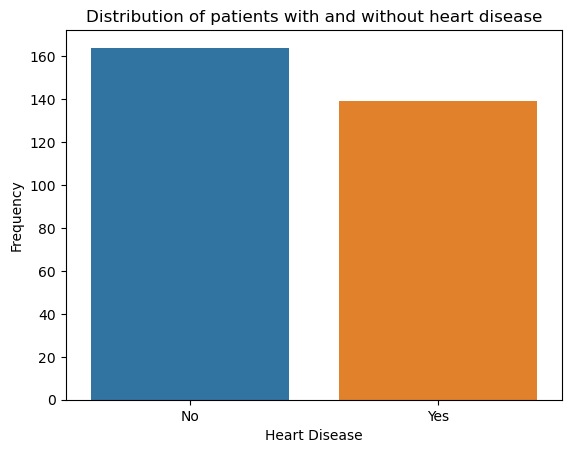

In [6]:
import warnings
warnings.filterwarnings('ignore')

sns.barplot(x = target.index, y = target.values)
plt.title('Distribution of patients with and without heart disease')
plt.xlabel('Heart Disease')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Frequency');

We are dealing with a relatively balanced dataset with no huge difference between the number of patients with heart disease and those without heart disease.

### Age

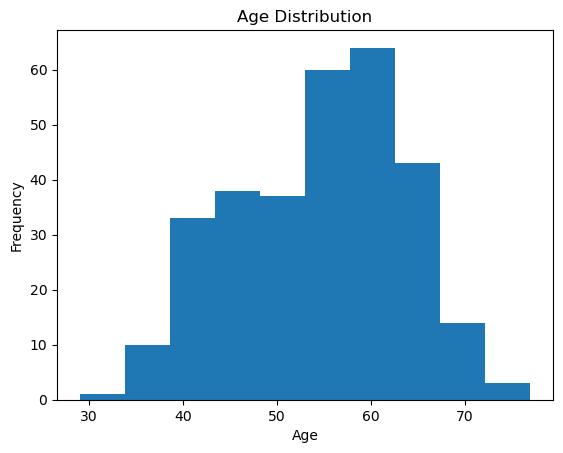

In [7]:
heart.age.plot.hist()
plt.title('Age Distribution')
plt.xlabel('Age');

The `age` feature is pretty fairly normally distributed in the dataset.
### Relationship between Cholesterol and Age and heart disease

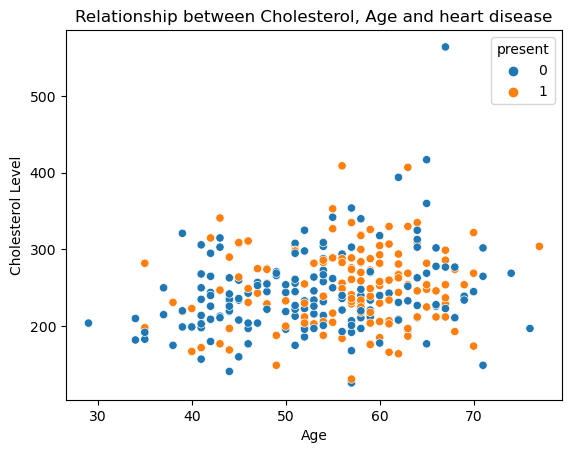

In [8]:
sns.scatterplot(x = 'age', y = 'chol', hue = 'present', data = heart)
plt.title('Relationship between Cholesterol, Age and heart disease')
plt.xlabel('Age')
plt.ylabel('Cholesterol Level');

* The plot shows that from the age of about 35 cholesterol level inclreases with age.

* The plot also shows that from the age of about 40 most people are highly likely to develop heart disease.
### Relationship between Cholesterol, Gender and heart disease

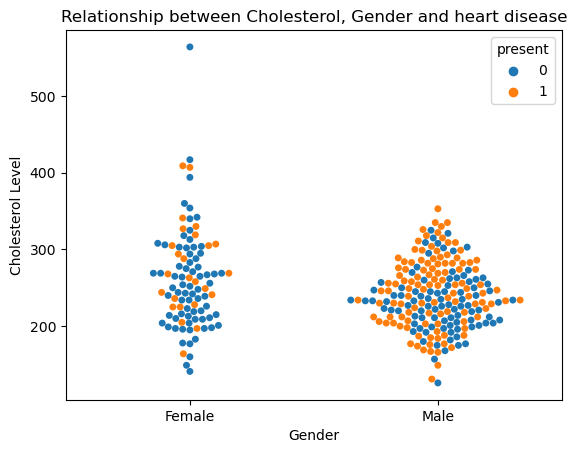

In [9]:
sns.swarmplot(x = 'sex', y = 'chol', hue = 'present', data = heart)
plt.xticks([0, 1], ['Female', 'Male'])
plt.xlabel('Gender')
plt.ylabel('Cholesterol Level')
plt.title('Relationship between Cholesterol, Gender and heart disease');

**Men are very susceptible to heart disease even with low cholesterol levels!**
### Gender

In [10]:
gender_count = heart.sex.value_counts()
gender_count

sex
1    206
0     97
Name: count, dtype: int64

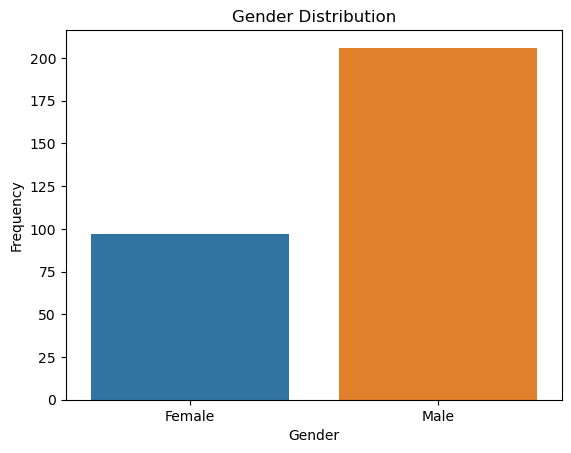

In [11]:
sns.barplot(x = gender_count.index, y = gender_count.values)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.xticks([1, 0], ['Male', 'Female'])
plt.ylabel('Frequency');

The dataset is highly skewed or imbalanced towards male patients with **206** observations corresponding to male patients, whereas only **97** correspond to female patients. This could potentially induce a bias in our classification model and negatively impact predictions for any female patients in any unseen data.

**This statistics also suggests that more males suffer from heart disease than females**.

### Relationship between Gender and Age and heart disease

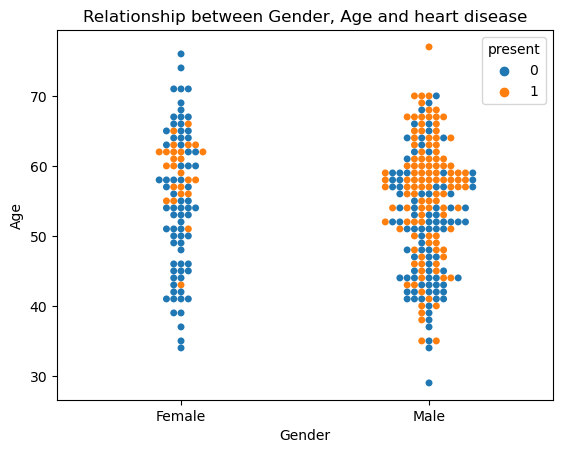

In [12]:
sns.swarmplot(x = 'sex', y = 'age', hue = 'present', data = heart)
plt.title('Relationship between Gender, Age and heart disease')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.xticks([1, 0], ['Male', 'Female']);

The plot shows that the **male gender** starts developing heart disease at a very early age of about **35 years** while **females** start having heart disease from about **50** years!

### Relationship between Chest Pain, Age and heart disease

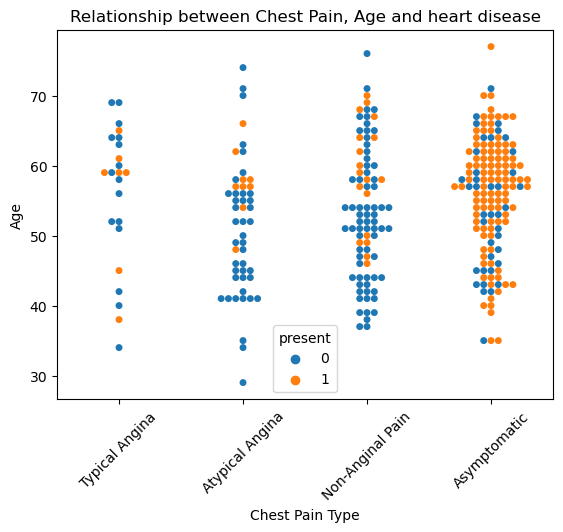

In [13]:
sns.swarmplot(x = 'cp', y = 'age', hue = 'present', data = heart)
plt.title('Relationship between Chest Pain, Age and heart disease')
plt.xlabel('Chest Pain Type')
plt.ylabel('Age')
plt.xticks([0, 1, 2, 3], ['Typical Angina', 'Atypical Angina', 'Non-Anginal Pain', 'Asymptomatic'], rotation = 45);

It can be seen that the **Asymptomatic** chest pain type is a **leading sign of the presence of heart disease** than the other chest pain types.

Patients as young as **35 years** can develop **Asymptomatic** chest pain! As we have seen already, **these are most middle age males!**

### Relationship between fasting blood sugar, Age and heart disease

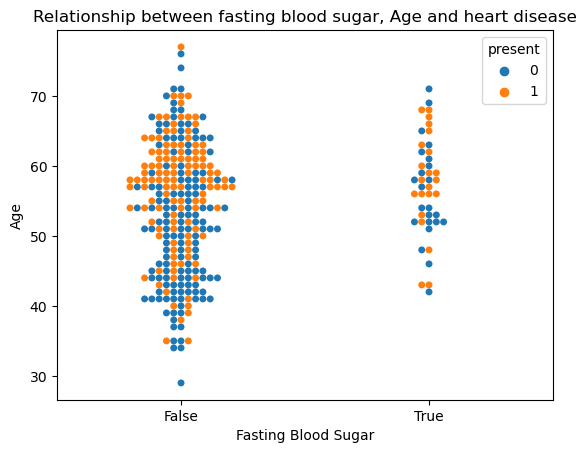

In [14]:
sns.swarmplot(x = 'fbs', y = 'age', hue = 'present', data = heart)
plt.title('Relationship between fasting blood sugar, Age and heart disease')
plt.xlabel('Fasting Blood Sugar')
plt.ylabel('Age')
plt.xticks([0, 1], ['False', 'True']);

* The dataset contains more patients without **fasting blood sugar** than those with **fasting blood sugar**.

* People start having **fasting blood sugar** as early as 35 years and this is when heart disease begins to develop, especially in males.

### Relationship between resting electrocardiographic results, Age and heart disease

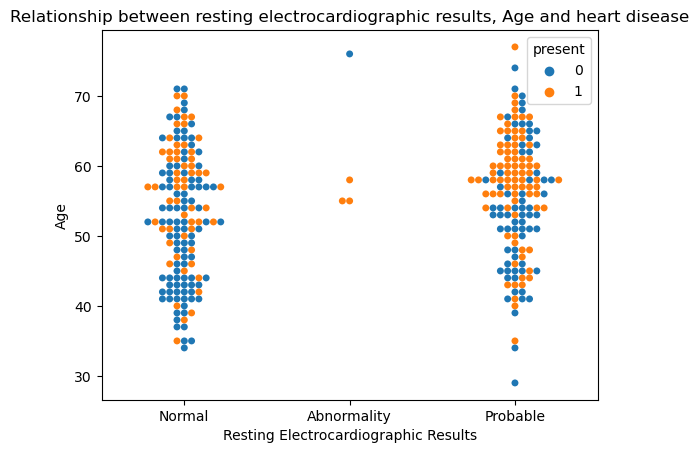

In [15]:
sns.swarmplot(x = 'restecg', y = 'age', hue = 'present', data = heart)
plt.title('Relationship between resting electrocardiographic results, Age and heart disease')
plt.xlabel('Resting Electrocardiographic Results')
plt.ylabel('Age')
plt.xticks([0, 1, 2], ['Normal', 'Abnormality', 'Probable']);

* The dataset has only 4 patients with **abnormal Resting Electrocardiographic Results**.
* Patients show **normal** or **probable/definite Resting Electrocardiographic Results** from the age of about **35 years** and this is the age when men start developing heart disease.
### Relationship between exercise induced angina, Age and heart disease

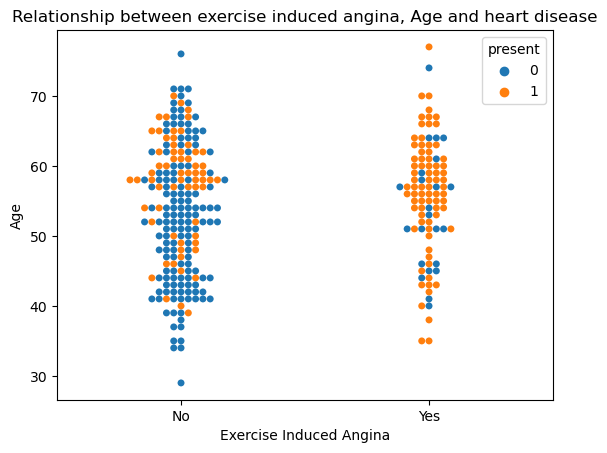

In [16]:
sns.swarmplot(x = 'exang', y = 'age', hue = 'present', data = heart)
plt.title('Relationship between exercise induced angina, Age and heart disease')
plt.xlabel('Exercise Induced Angina')
plt.ylabel('Age')
plt.xticks([0, 1], ['No', 'Yes']);

Irrespective of age, **exercise induced angina** is a leading cause of heart disease!

**All the features seem to have some merits! They seem to correlate or contribute to a person developing a heart disease. I'll use all the features in training a `baseline line` model, then check for `feature importance` to select the features which correlate more with the target, then train the final model.**

### Create dummies for Categorical features
The following columns are categorical in nature `'cp', 'slope', 'thal'` since the numbers do not represent ordering or ranking. We shall convert these into dummies.

### Let's investigate the two string object columns

In [17]:
heart.thal.value_counts()

thal
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64

In [18]:
heart.ca.value_counts()

ca
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: count, dtype: int64

**These two features contain a non-numeric character. Let's replace this character with the value with the lowest frequency and convert the features to numbers**

In [19]:
# heart['thal'] = heart.thal.str.replace('\D', '6.0', regex = True).astype(float)
# heart['ca'] = heart.ca.str.replace('\D', '3.0', regex = True).astype(float)
heart['thal'] = heart.thal.str.replace('?', '6.0').astype(float)
heart['ca'] = heart.ca.str.replace('?', '3.0').astype(float)

In [20]:
df = heart.copy()

df = pd.get_dummies(df, columns = ['cp', 'slope', 'thal'], drop_first = True)
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,present,cp_2,cp_3,cp_4,slope_2,slope_3,thal_6.0,thal_7.0
0,63,1,145,233,1,2,150,0,2.3,0.0,0,False,False,False,False,True,True,False
1,67,1,160,286,0,2,108,1,1.5,3.0,1,False,False,True,True,False,False,False
2,67,1,120,229,0,2,129,1,2.6,2.0,1,False,False,True,True,False,False,True
3,37,1,130,250,0,0,187,0,3.5,0.0,0,False,True,False,False,True,False,False
4,41,0,130,204,0,2,172,0,1.4,0.0,0,True,False,False,False,False,False,False


### Train - Test split

In [21]:
X = df.drop('present', axis = 1)
y = df.present
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 525)

### Min - Max Scaling
Computers and machine learning algorithms treat larger numbers as having higher values than smaller numbers. The impact is more serious with algorithms that depend on distance metrics and this includes most classification algorithm. Some of the numerical features in our dataset are measured using different scales. These features can be converted to similar scales by rescaling their values to a specific range for example using min-max scaling.

$$X_{scale} = \frac{x - min(x)}{max(x) - min(x)}$$

The following features would probably need scaling **`'age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca'`**.

### Building the Model
It has been decided that we shall use **`LogisticRegression`** in this project. We'll first train the model without scaling the features and with default parameters to get a ***baseline*** model.

In [22]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
acc_train = log_reg.score(X_train, y_train)
y_pred = log_reg.predict(X_test)
acc_test = log_reg.score(X_test, y_test)

print(f'Train accuracy: {acc_train}')
print(f'Test accuracy: {acc_test}')

Train accuracy: 0.871900826446281
Test accuracy: 0.8032786885245902


The ***baseline*** model without feature scaling or hyperparameter tuning is more than **`80%`** accurate! Let's check at where the model got confused...

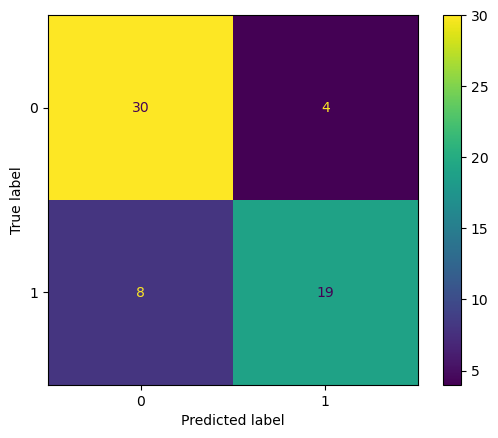

In [23]:
confusion = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion, display_labels = log_reg.classes_)
disp.plot();

**The model got `12` predictions wrong!** We would try to improve upon this using **`feature scaling, hyperparameter tuning`** and **`feature selection`**

### Feature Importance
**`LogisticRegression`** object does not the **`feature_importance_`** attribute. We'll have to find a way to get around it as below.

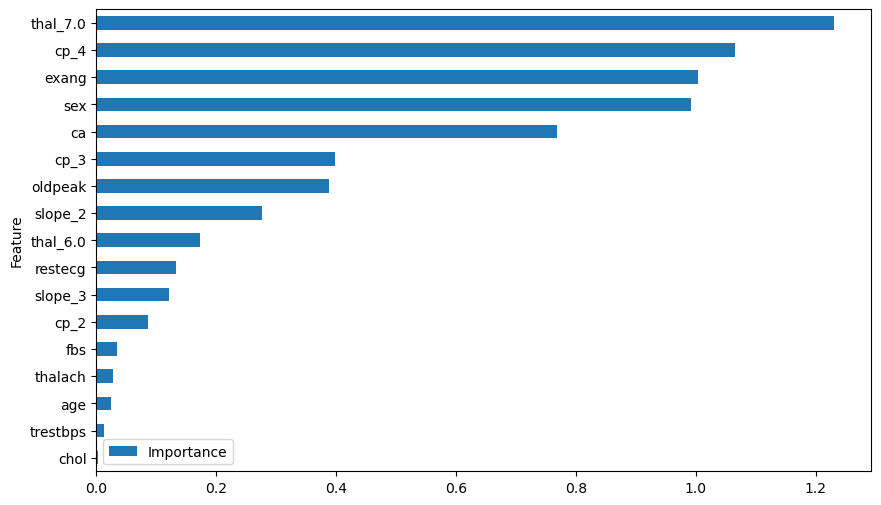

In [24]:
coefficients = log_reg.coef_[0]

feature_importance = pd.DataFrame({'Feature': list(X_test), 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

**It is surprising to see that `age` and `cholesterol level` are not important predictors for heart disease!**
## Selecting the top 12 features for our model

In [25]:
selected_features = feature_importance.sort_values(by = 'Importance', ascending = False).Feature.head(12).values
selected_features

array(['thal_7.0', 'cp_4', 'exang', 'sex', 'ca', 'cp_3', 'oldpeak',
       'slope_2', 'thal_6.0', 'restecg', 'slope_3', 'cp_2'], dtype=object)

## Hyperparameter tuning for Logistic Regression

In [26]:
X_train_selected = X_train.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]

In [27]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

log_reg = LogisticRegression()

log_reg_gs = GridSearchCV(log_reg, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
log_reg_gs.fit(X_train_selected, y_train)
best_score = log_reg_gs.best_score_
best_params = log_reg_gs.best_params_

print(best_score)
print(best_params)

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits
0.8428571428571429
{'C': 0.615848211066026, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


In [28]:
accuracy = log_reg_gs.best_estimator_.score(X_test_selected, y_test)
print(accuracy)

0.8032786885245902


### Observations
Going from **18 features** down to **12 features** means some **loss of information** and this would be accompanied by a corresponding **loss in accuracy**. The training accuracy has dropped from **88%** to **86%** while the test accuracy has dropped from **83%** to **80%**. 

We'll now scale the following features `'oldpeak', 'ca'` and retrain the model using the best parameters.

In [29]:
cols = ['oldpeak', 'ca']
X_train_scaled = X_train_selected.copy()
for col in cols:
    scaler = MinMaxScaler()
    X_train_scaled[col] = scaler.fit_transform(X_train_scaled[[col]])
    
X_train_scaled.head()

,thal_7.0,cp_4,exang,sex,ca,cp_3,oldpeak,slope_2,thal_6.0,restecg,slope_3,cp_2
2,True,True,1,1,0.666667,False,0.464286,True,False,2,False,False
102,False,True,0,0,0.333333,False,0.000000,False,False,2,False,False
206,True,True,1,1,0.666667,False,0.535714,True,False,2,False,False
209,False,True,1,0,0.000000,False,0.250000,True,False,0,False,False
156,True,True,1,1,0.000000,False,0.285714,False,False,0,False,False


In [30]:
cols = ['oldpeak', 'ca']
X_test_scaled = X_test_selected.copy()
for col in cols:
    scaler = MinMaxScaler()
    X_test_scaled[col] = scaler.fit_transform(X_test_scaled[[col]])

In [42]:
log_reg_model = LogisticRegression(C = 0.615848211066026, max_iter = 100, penalty = 'l2', solver = 'lbfgs')
log_reg_model.fit(X_train_scaled, y_train)

acc_train = log_reg_model.score(X_train_scaled, y_train)
y_pred = log_reg_model.predict(X_test_scaled)
acc_test = log_reg_model.score(X_test_scaled, y_test)

print(f'Train accuracy: {acc_train}')
print(f'Test accuracy: {acc_test}')

Train accuracy: 0.8305785123966942
Test accuracy: 0.7868852459016393


## Training the same model without scaling features

In [43]:
log_reg_model = LogisticRegression(C = 0.615848211066026, max_iter = 100, penalty = 'l2', solver = 'lbfgs')
log_reg_model.fit(X_train_selected, y_train)

acc_train = log_reg_model.score(X_train_selected, y_train)
y_pred = log_reg_model.predict(X_test_selected)
acc_test = log_reg_model.score(X_test_selected, y_test)

print(f'Train accuracy: {acc_train}')
print(f'Test accuracy: {acc_test}')

Train accuracy: 0.8553719008264463
Test accuracy: 0.8032786885245902


**As we can see feature scaling using `MinMaxScaler` has not proven to be useful for this model.**
### Evaluating the model
#### Confusion Matrix

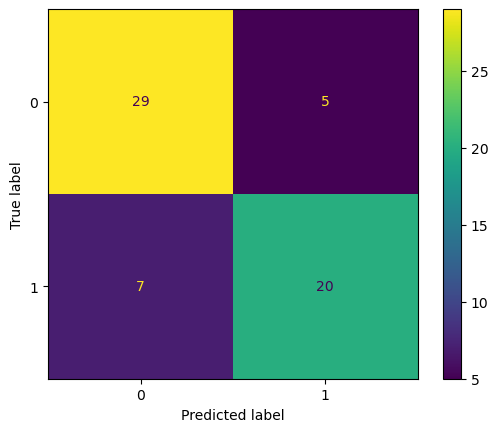

In [44]:
confusion = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion, display_labels = log_reg_model.classes_)
disp.plot();

### Observations
* Train accuracy: `86%`
* Test accuracy: `80%`
* The model gets confused in 12 cases
    * The model classified 5 **healthy people** as having a **heart disease** (**`False Positive` or `Type I error`**)
    * The model classified 7 **heart disease patients** as **healthy people** (**`False Negative` or `Type II error`**)
    
* The number of wrong predictions remains 12. However, **the number of FN has dropped from 8 to 7**. Which is good news for model's **precision** score.
    
#### Important Note:
With **Type I error**, the healthy individual would have to through treatment. If it were wrong cancer diagnose the individual would have to undergo **chemotherapy** with the accompanying side effects!

With **Type II error**, the sick individual would probably **NOT get any treatment and might even die from the illness!!**

The question is often asked, which of these errors is better? Well, it depends on the application. In the case of detecting illness, **the goal is to make sure that no illness go undetected!** The consequences of missing to detect an illness is more serious than the side effects incurred from administrying treatment on a healthy individual.

To improve your belief of having a disease or not having one, **it's highly recommended to go for a second test** in order to double sure about the likelihood or having the disease or free from it. There is, however, a caveat here! The second test should be from the same test provider (not the same testing clinic). This is because **it's very unlikely for the same test to make an error on same patient twice!** If it would, well...

### Sensitivity (Recall)
If we are interested in focusing on how well the model performs on **`class 1 or positive cases`**, we look to a metric called **sensitivity**. This is **`the proportion of CLASS 1 PREDICTIONS out of TOTAL CLASS 1 cases`**. It answers the question **What is the proportion of CLASS 1 PREDICTIONS are correct predictions**? or **Given that an observation is a CLASS 1, what is the probability of predicting it correctly**? It is defined as

$$Sensitivity = \frac{TP}{TP + FN}$$

Sensitivity is also referred to as **Recall**.

NOTE: **`TP, TN, FP, FN`** can be read off the **confusion matrix**

In [45]:
tp = sum((y_test == 1) & (y_pred == 1))
fn = sum((y_test == 1) & (y_pred == 0))
sensitivity = tp / (tp + fn)
print(f'The Sensitivity is: {sensitivity * 100: .2f}%')

The Sensitivity is:  74.07%


### Specificity
**Specificity** has a similar interpretation as sensitivity, but it's concerned with **class 0**. 

This is **`the proportion of CLASS 0 PREDICTIONS out of TOTAL CLASS 0 cases`**. It answers the question **What is the proportion of CLASS 0 PREDICTIONS that are correct predictions**? or **Given that an observation is a CLASS 0, what is the probability of predicting it correctly**? 

$$Specificity = \frac{TN}{TN + FP}$$

In [46]:
tn = sum((y_test == 0) & (y_pred == 0))
fp = sum((y_test == 0) & (y_pred == 1))
specificity = tn / (tn + fp)
print(f'The Specificity is: {specificity * 100: .2f}%')

The Specificity is:  85.29%


### Precision (Positive Predictive Value)
In calculating **Sensitivity** and **Specificity** we use known classes (**`1`** or **`0`**). But what if we don't know the classes? A person may be feeling sick, but we don't actually know whether he's sick or not. We need to use the result from this model to try to predict his health status - **sick (1)** or **not sick (0)**. How are we going to know if the prediction is correct? We need, therefore, to know how **precise** our model is. **Precision** is defined as:

$$Precision or Positive Predictive Value = \frac{TP}{TP + FP}$$

**NOTE:** This is what test manufactures / providers quote to sell their product! They would say ***Our COVID-19 test has a precision of 95%***. 

In [47]:
tp = sum((y_test == 1) & (y_pred == 1))
fp = sum((y_test == 0) & (y_pred == 1))
precision = tp / (tp + fp)
print(f'The Precision is: {precision * 100: .2f}%')

The Precision is:  80.00%


### Negative Predictive Value
Like **Positive Predictive Value** but for **class 0**. Here we would be interested in making sure that the **negative predictions from unknown observations are truly negative**, so we'd be interested in checking the NPV in this case.

$$Negative Predictive Value = \frac{TN}{TN + FN}$$

In [48]:
tn = sum((y_test == 0) & (y_pred == 0))
fn = sum((y_test == 1) & (y_pred == 0))
npv = tn / (tn + fn)
print(f'The Negative Predictive Value (NPV) is: {npv * 100: .2f}%')

The Negative Predictive Value (NPV) is:  80.56%


### Receiver Operating Characteristic (ROC) Curve
The Receiver Operating Characteristic is another way of guaging the performance of a binary classifier. It uses the area under the ROC curve (AUC) as a metric. A model whose predictions are **all wrong** has an **AUC of 0.0 (`0%`)** while one whose predictions are **all correct** has an **AUC of 1.0 (`100%`)**.
#### Helper Function to plot ROC curve

In [49]:
def auc_curve(y_test, y_pred):
    plt.plot([0,1], [0,1], 'r--')

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    label = 'Model AUC:' + ' {0:.2f}'.format(roc_auc)
    plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 2)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.title('Receiver Operating Characteristic', fontsize = 14)
    plt.legend(loc = 'lower right', fontsize = 12)
    plt.show()

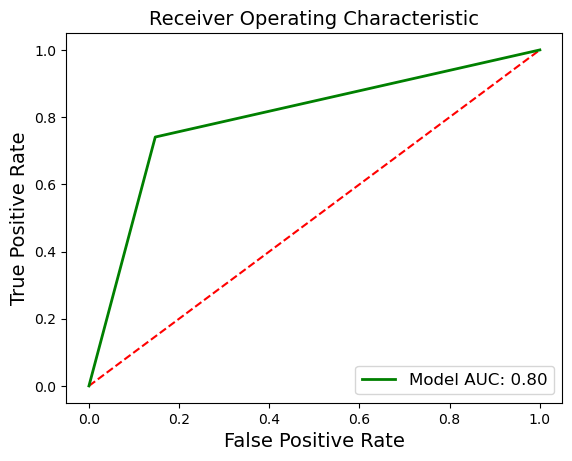

In [50]:
auc_curve(y_test, y_pred)

Our model has an AUC of 0.80 (80%) which indicates that it's a good model! But it still needs improvement.
### Cummulative Accuracy Profile (CAP) Curve
The CAP shows how robust the model is! It gives an indication of the benefits of using a model over not using one (manual process of testing). It focuses on how robust the model is at detecting the positive class. **This is what would convince top management to invest in developing a model for detecting heart disease or any other disease.**

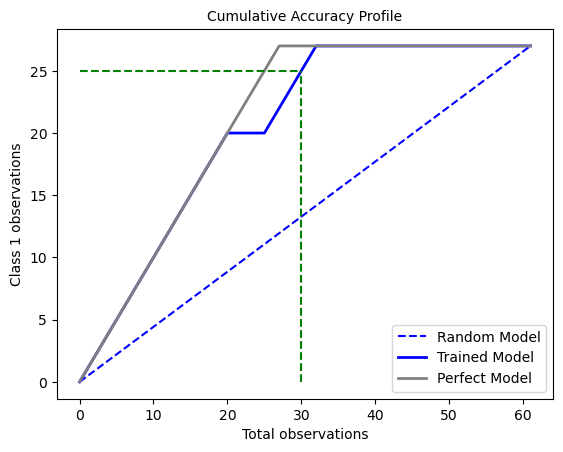

Percentage: 92.59%

    Interpret this percentage as follows:
    
    1. Less than 60%: Useless Model
    2. 60% - 70%: Poor Model
    3. 70% - 80%: Good Model
    4. 80% - 90%: Very Good Model
    5. More than 90%: Too Good to be True.

    In the fifth case, one must always check for overfitting.
    


In [51]:
cap_curve(y_test, y_pred)

The model's CAP curve shows we are having **`92.59%`**! This falls in the range **more than 90%** which is labelled as **"Too Good to be True"**! This means the model is able of processing **50%** of cases with an accuracy of **92.59% of detecting class 1 cases** compared to manual or random pick with an accuracy of 50%. This means the model is capable of correctly predicting **92%** of patients with a heart disease after processing 50% of the data. The added advantage is that the model would be fast (avoid backlog / waiting in long queue), less human resources and less expensive (few people on salary!).

The model's performance is **"Too Good to be True"**! However, with **`Train accuracy = 86%`** and **`Test accuracy = 80%`**, there is no visible sign of overfitting.

## Conclusions
* With a test accuracy of `80%`, the model is not doing badly, but it's not good enough for the application of detecting heart disease
* The model was trained and tested with just **`303`**! This is certainly not enough data to train a model for such an application. More data is needed to train and deploy the model in production.
* Other classification algorithms like **`RandomForestClassifier`** or **`KNeighborsClassifier`** could also be good models to train for such tasks.